# Dimensionality reduction with LDA

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sekhansen/text_algorithms_econ/blob/main/notebooks/3_LDA.ipynb)


This notebook introduces how to use the [```lda```](https://lda.readthedocs.io/en/latest/autoapi/lda/index.html) Python library for estimating Latent Dirichlet Allocation using the collapsed Gibbs sampling algorithm of Griffiths and Steyvers (2004).

To illustrate LDA, the tutorial uses text data obtained from minutes from the [Monetary Policy Committee](https://www.bankofengland.co.uk/about/people/monetary-policy-committee) meetings at the Bank of England. You can browse through all of these minutes [here](https://www.bankofengland.co.uk/monetary-policy-summary-and-minutes/monetary-policy-summary-and-minutes).

In [ ]:
# install required libraries
!pip3 install flashtext                  # easy phrase replacing methods
!pip3 install contractions               # expand English contractions
!pip3 install spacy                      # functions for lemmatizing
!pip3 install gdown                      # download files from Google Drive
!pip3 install nltk                       # NLP library
!pip3 install lda                        # LDA library
!pip3 install wordcloud                  # library for wordclouds

# install Spacy's language model
# for more languages and models check: https://spacy.io/models
!python3 -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9308 sha256=b963f688407ef3ca290bde715079167eb7734a4b5089f677916965828b1008cc
  Stored in directory: /root/.cache/pip/wheels/65/3c/c7/44672c5062c16d05760b1eaddbf611d2f6a4b715c6d6777418
Successfully built flashtext
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 12.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking i

In [2]:
# clone the GitHub repository with the preprocessing scripts
!git clone https://github.com/unstructured-data-research/text-preprocessing

Cloning into 'text-preprocessing'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 31 (delta 11), reused 17 (delta 4), pack-reused 0
Unpacking objects: 100% (31/31), 1.95 MiB | 6.70 MiB/s, done.


In [3]:
# import required libraries
import gdown
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
import lda

import spacy
nlp_standard = spacy.load('en_core_web_sm')

# import our own modules
sys.path.append('./text-preprocessing/src')
import preprocessing_class as pc
import preprocess_data

In [4]:
# define dictionary with paths to data and Python scripts in Google Drive
urls_dict = {"mpc_minutes": ("https://drive.google.com/uc?id=1k086m12gBHKuVMPv4GUD1aB_kZOZpznR", "txt")
             }

In [5]:
# download all files
for file_name, attributes in urls_dict.items():
    url = attributes[0]
    extension = attributes[1]
    gdown.download(url, f"./{file_name}.{extension}", quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=1k086m12gBHKuVMPv4GUD1aB_kZOZpznR
To: /content/mpc_minutes.txt
100%|██████████| 7.36M/7.36M [00:00<00:00, 167MB/s]


# MPC Minutes

We will illustrate LDA using the MPC minutes data. We will re-create one particular figure in Andy Haldane's speech [*Central bank psychology*]( http://bit.ly/2G7qoF3) in which he estimates the share of time the MPC minutes spend discusing banking. The figure is below:

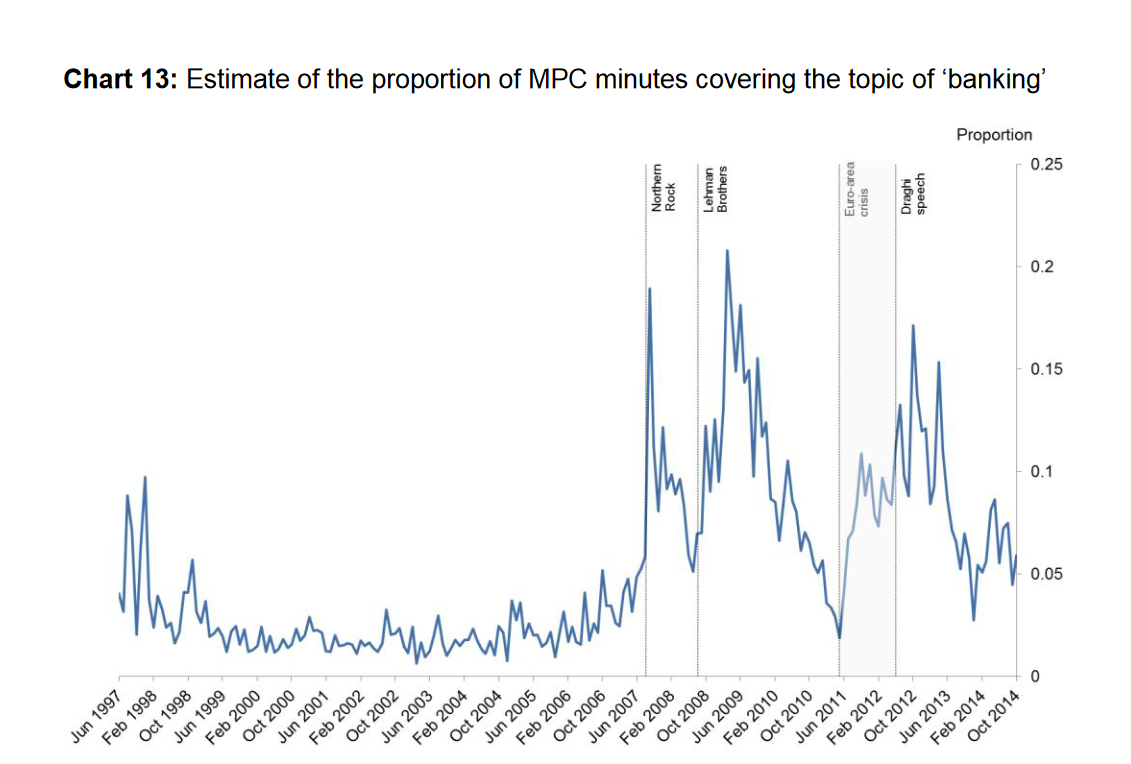

In [6]:
# load the MPC data
data = pd.read_csv("mpc_minutes.txt", sep="\t")
data

,year,minutes
0,199706,1 Sections I to V of this minute summarise t...
1,199706,The 12-month growth rate of notes and coins ...
2,199706,"Broad money, too, decelerated in April: its ..."
3,199706,Lending growth continued at around 9% in ...
4,199706,Lending to individuals remained robust in...
...,...,...
7272,201410,"For most members, there remained insuffi..."
7273,201410,"Set against this, the level of Bank Rate..."
7274,201410,"For two members, economic circumstances ..."
7275,201410,The Governor invited the Committee to vo...


In [7]:
# explore one observation
data.loc[0, "minutes"]

'  1 Sections I to V of this minute summarise the analysis presented to the MPC by Bank staff and the BankÃ\x95s regional agents, and incorporate also information that became available to the Committee after the presentation but prior to the 6 June meeting.     Monetary conditions'

## Cleaning Raw Text Data

Before implementing a topic model, it is important to pre-process the data. To do this, we will use a custom-built preprocessing Python library. For a more detailed discussion on preprocessing check the *2_preprocessing.ipynb* notebook within this same repository.

We will start by creating a function that applies all the preprocessing steps in the correct order. We should provide the documents that we want to preprocess along side some key parameters. The function will return an object ```prep``` that we will use to later create a document-term matrix.


In [8]:
def apply_preprocessing(data, item_type, stopwords_type, replacing_dict, pattern, punctuation):
    """ Function to apply the steps from the preprocessing class in the correct
        order to generate a term frequency matrix
    """

    # initialize the class with the text data and some parameters
    prep = pc.RawDocs(data)

    # replace some specific phrases of interest
    prep.phrase_replace(replace_dict=replacing_dict, 
                        sort_dict=True,
                        case_sensitive_replacing=False)
    
    # lower-case text and expand contractions
    prep.basic_cleaning(lower_case=True,
                        contraction_split=True)

    # split the documents into tokens
    prep.tokenize_text(tokenization_pattern=pattern)

    # clean tokens (remove non-ascii characters, remove short tokens, remove punctuation and numbers)
    prep.token_clean(length=2, 
                    punctuation=punctuation, 
                    numbers=True)

    # remove stopwords
    if item_type == "tokens":
        prep.stopword_remove(items='tokens', stopwords=stopwords_type)
    elif item_type == "lemmas":
        prep.lemmatize()
        prep.stopword_remove("lemmas", stopwords=stopwords_type)
    elif item_type == "stems":
        prep.stem()
        prep.stopword_remove("stems", stopwords=stopwords_type)

    return prep

In [9]:
# define tokenization pattern and punctuation symbols
pattern = r"(?u)\b\w\w+\b"
punctuation = string.punctuation.replace("-", "")

In [10]:
# use preprocessing class
prep = apply_preprocessing(data["minutes"],      # our documents
                           "stems",              # tokens, stems or lemmas
                           "long",               # long or short
                           {},                   # dictionary with expressions we want to preserve
                           pattern,              # tokenization pattern
                           punctuation           # string with punctuation symbols to remove
                           )

Reading data from iterator


In [11]:
# inspect a particular tokenized document and compare it to its original form
i = 10
print(data["minutes"][i])
print("\n ------------------------------- \n")
print(prep.stems[i])

  There was as yet no clear downtrend in net exports. Exports to non-EU countries had risen sharply: the USA had grown very fast in Q1, but it was expected by US commentators to slow down spontaneously. Net exports to EU countries had been resilient. GDP growth in France and Germany (though not Italy) had picked up to just below trend, but domestic demand growth in those countries had been subdued.

 ------------------------------- 

['yet', 'clear', 'downtrend', 'net', 'export', 'export', 'non', 'countri', 'risen', 'sharpli', 'usa', 'grown', 'veri', 'fast', 'expect', 'comment', 'slow', 'spontan', 'net', 'export', 'countri', 'resili', 'gdp', 'growth', 'franc', 'germani', 'though', 'itali', 'pick', 'trend', 'domest', 'demand', 'growth', 'countri', 'subdu']


The final step in pre-processing is to drop remaining words that are not useful for identifying content.  We have already dropped standard stopwords, but there may also be data-dependent common words.  For example, in data from Supreme Court proceedings, "justice" might be treated as a stopword.  Also, words that appear just once or twice in the collection are not informative of content either.  Ideally, one would like a measure of informativeness that both punishes common words in the data, and rare words.  One such option is to give each stem a tf-idf (term frequency - inverse document frequency) score.  This is standard in the language processing literature, so we omit details here.

In [12]:
# generate document frequency ranking for stems
prep.get_term_ranking("stems", score_type="df")

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [13]:
# explore top stems
prep.df_ranking["stems"][0:10]

[(3431.0, 'growth', 0),
 (3350.0, 'rate', 1),
 (3065.0, 'inflat', 2),
 (3061.0, 'month', 3),
 (2852.0, 'price', 4),
 (2767.0, 'market', 5),
 (2558.0, 'increas', 6),
 (2530.0, 'committe', 7),
 (2527.0, 'expect', 8),
 (2259.0, 'year', 9)]

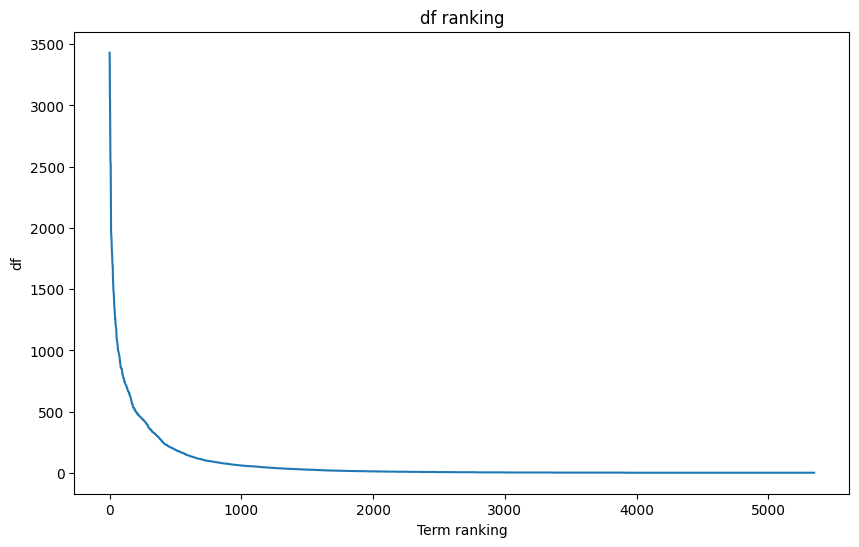

In [14]:
# plot df ranking
plt.figure(figsize=(10,6))
plt.plot([x[0] for x in prep.df_ranking["stems"]])
plt.title('df ranking')
plt.ylabel("df")
plt.xlabel("Term ranking")
plt.show()

In [15]:
# generate term frequency inverse document frequency ranking of stems
prep.get_term_ranking("stems", score_type="tfidf")

In [16]:
# explore top stems
prep.tfidf_ranking["stems"][0:10]

[(29.825243257254172, 'nfc', 0),
 (29.417855025455637, 'ip', 1),
 (28.780350233635524, 'securitis', 2),
 (28.20096850526625, 'surveya', 3),
 (28.09284413266011, 'pnfcsa', 4),
 (28.013583133605582, 'attack', 5),
 (27.89033249950207, 'bcc', 6),
 (27.731835312191592, 'egard', 7),
 (27.221006498334184, 'annex', 8),
 (27.177586953744225, 'gear', 9)]

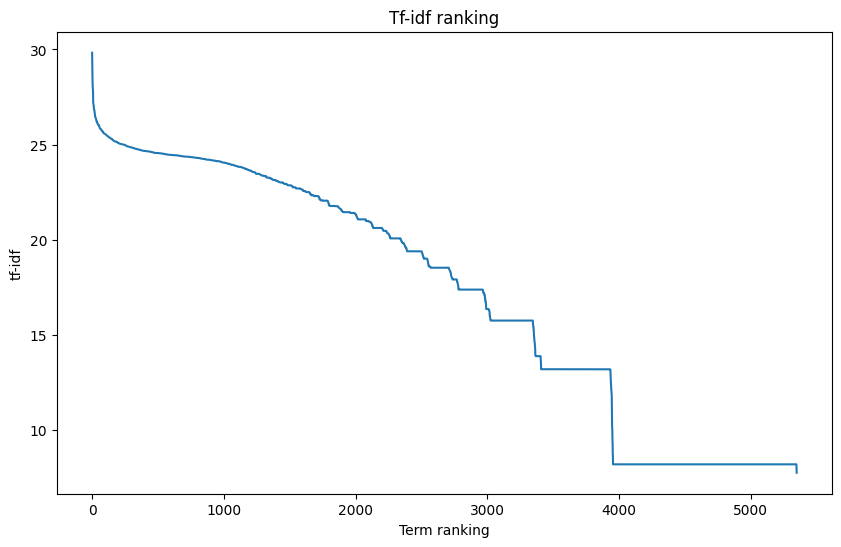

In [17]:
# plot tfidf ranking
plt.figure(figsize=(10,6))
plt.plot([x[0] for x in prep.tfidf_ranking["stems"]])
plt.title('Tf-idf ranking')
plt.ylabel("tf-idf")
plt.xlabel("Term ranking")
plt.show()

At this stage, the user can decide how many stems to drop based on either the df or tf-idf scores.  The first argument to rank_remove defines whether to drop from "tokens" or "stems" (since we formed the rankings based on stems above, we should specify stems) and the second specifies the ranking method to use ("df" or "tfidf"). Finally, you can either provide a *min_cutoff_value* which will remove all items with a score below the value or a *max_cutoff_value* which will remove all items with a score above the value.

One can determine the cutoffs from exploring rankings that we have already created. Here we plot the ranking in Python, which indicates a reasonable cutoff minimum cutoff around the term in position 3,500.

In [26]:
# remove stems with a tfidf score equal or lower than the score of stem 3,500
cutoff_score = prep.tfidf_ranking["stems"][3500][0]
cutoff_score

13.19615492862266

In [27]:
# apply removal
prep.rank_remove("stems", "tfidf", min_cutoff_score=cutoff_score)

In [28]:
# create document-term matrix using stems
prep.dt_matrix_create(items='stems', score_type='df')
# extract document-term matrix
dt_matrix_stems = prep.df_matrix["stems"].astype(int)
print(dt_matrix_stems.shape)

(7277, 3408)


In [29]:
# get the vocabulary and the appropriate dictionaries to map from indices to words
word2idx = prep.vocabulary["stems"]
idx2word = {i:word for word,i in word2idx.items()}

In [30]:
all_stems = [s for d in prep.stems for s in d]
print("number of unique stems = %d" % len(set(all_stems)))
print("number of total stems = %d" % len(all_stems))

number of unique stems = 3408
number of total stems = 496792


After pre-processing, we have 3,408 unique stems We now proceed to estimate a topic model on them.

## Estimating a Topic Model

The first step in estimation is to initialize a model using the LDA class.  We will pass the list of stems we just created as the set of documents.

There are three main parameters in LDA, the number of topics, and the two hyperparameters of the Dirichlet priors.  We will follow the advice of Griffiths and Steyvers (2004) and set the hyperparameter of the Dirichlet prior on topics to $200/V$, where $V$ is the number of unique vocabulary elements, and the hyperparameter of the Dirichlet prior on document-topic distributions to $50/K$, where $K$ is the number of topics.

In [31]:
# create LDA object with our parameters
num_topics = 30
vocab_size = dt_matrix_stems.shape[1]
lda_model = lda.LDA(n_topics=num_topics,         # Number of topics
                    alpha=50/num_topics,         # Dirichlet parameter for distribution over topics
                    eta=200/vocab_size,          # Dirichlet parameter for distribution over words
                    n_iter=5000,                 # Number of sampling iterations
                    random_state=92              # The generator used for the initial topics
                    )

lda_model

In [32]:
# check some paramters
print(lda_model.alpha)
print(lda_model.eta)
print(lda_model.n_topics)

1.6666666666666667
0.05868544600938967
30


In [33]:
# estimate model (takes around 7 minutes)
lda_model.fit(dt_matrix_stems)

In [34]:
# topics: probability distribution over the vocabulary (num_topics x vocab_size)
lda_model.topic_word_.shape

(30, 3408)

In [35]:
# distribution of topics over documents (num_documents x num_topics)
lda_model.doc_topic_.shape

(7277, 30)

The estimated topics are represented by a $\text{Num Topics} \times \text{Vocab Size} $ matrix ($30 \times 3408$ in our case)  whose rows sum to one, while the estimated distribution of topics within documents are represented by a $\text{Num Documents} \times \text{Num Topics} $ matrix ($7277\times 30$ in our case) rows sum to one as well.  

To get an idea of the topics that have been estimated, and whether they make sense, we will explore the stems with the highest probability for each topic. It's a good idea to check the topics are "reasonable" before proceeding with any analysis.

In [36]:
# explore the words with highest probability per topic
topics_dist = lda_model.topic_word_
n_top_words = 15
for i, topic_dist in enumerate(topics_dist):
    top_idxs = np.argsort(topic_dist)[:-n_top_words:-1]
    top_words = [idx2word[idx] for idx in top_idxs]
    print('Topic {}: {}'.format(i, ' '.join(top_words)))

Topic 0: world slowdown activ global countri econom emerg prospect outlook affect particular japan slow far
Topic 1: risk target medium outlook downsid balanc member upsid near uncertainti abov prospect view news
Topic 2: decis immedi develop discuss befor financi cost turn credit money note intern world consider
Topic 3: oil higher reflect pressur commod import suppli futur produc input upward good past energi
Topic 4: invest level possibl weak busi lower relat past howev low sector earli perhap surpris
Topic 5: recoveri activ indic although half modest onli pace pickup global sustain prospect weak pick
Topic 6: sterl effect exchang depreci relat appreci dollar movement sinc chang sterlinga past meet around
Topic 7: employ earn labour unemploy pay measur sector settlement wage averag work privat lfs bonus
Topic 8: cpi line ahead near measur dure pre time impact reflect energi around abov part
Topic 9: trade domest export net contribut import posit weak account larg strong offset exter

In [37]:
# define a set of colors for each topic
cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
n_top_words = 15
# create a wordcloud object
cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=n_top_words,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

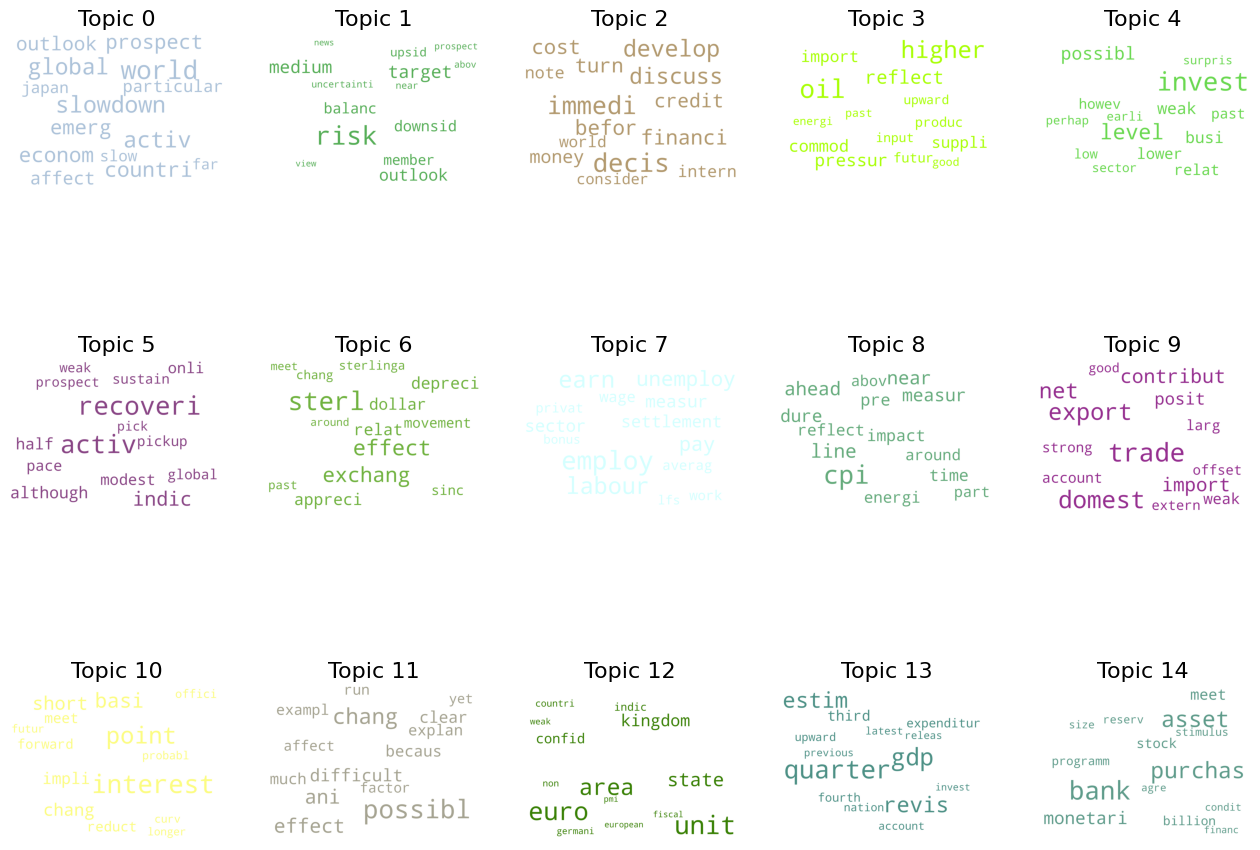

In [38]:
# create figure for the first 15 topics
fig, axes = plt.subplots(3, 5, figsize=(16,12), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    
    # select top words from topic
    topic_dist = topics_dist[i]
    top_idxs = np.argsort(topic_dist)[:-n_top_words:-1]
    top_words = [idx2word[idx] for idx in top_idxs]
    top_probs = [topic_dist[idx] for idx in top_idxs]
    plot_dict = {top_words[i]:top_probs[i] for i in range(len(top_words))}

    # generate subplot    
    fig.add_subplot(ax)
    cloud.generate_from_frequencies(plot_dict, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

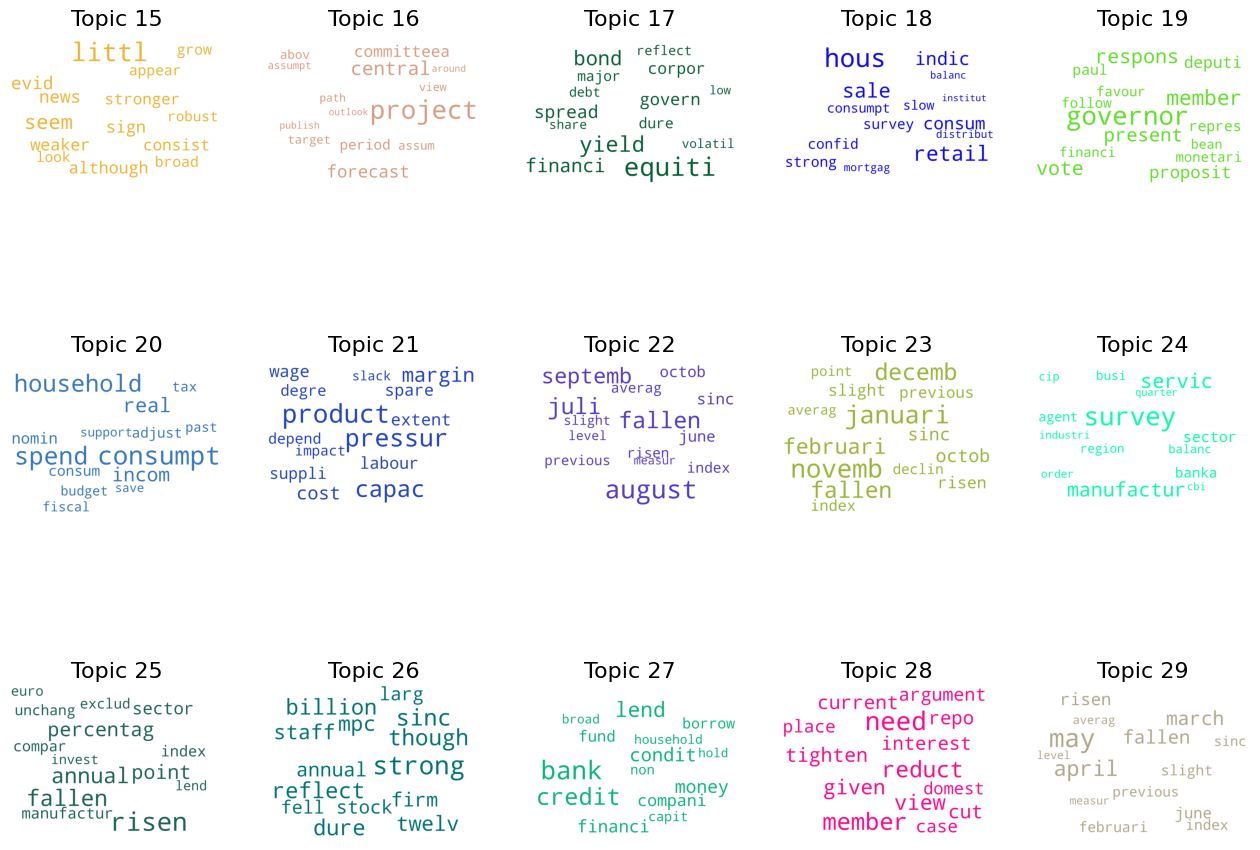

In [40]:
# create figure for the last 15 topics
fig, axes = plt.subplots(3, 5, figsize=(16,12), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten(), 15):
    
    # select top words from topic
    topic_dist = topics_dist[i]
    top_idxs = np.argsort(topic_dist)[:-n_top_words:-1]
    top_words = [idx2word[idx] for idx in top_idxs]
    top_probs = [topic_dist[idx] for idx in top_idxs]
    plot_dict = {top_words[i]:top_probs[i] for i in range(len(top_words))}

    # generate subplot    
    fig.add_subplot(ax)
    cloud.generate_from_frequencies(plot_dict, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

In this particular topic model, topic 27 appears to be about banking and financial markets.


In [43]:
n_top_words = 20
target_topic = 27
topic_dist = topics_dist[target_topic]
top_idxs = np.argsort(topic_dist)[:-n_top_words:-1]
top_words = [idx2word[idx] for idx in top_idxs]
print('Topic {}: {}'.format(target_topic, ' '.join(top_words)))

Topic 27: bank credit lend condit money financi compani fund borrow non capit household broad hold corpor cost sector mortgag avail


## Querying Using Estimated Topics

After estimating a topic model, one is often interested in estimating the distribution of topics for documents not included in estimation.  In this case, one option is to $\textit{query}$ those documents by holding fixed the topics estimated from LDA, and only estimating the distribution of topics for the out-of-sample documents.  The ```lda``` library also provides a way to do this through the ```transform()``` function.

We will apply querying to the corpus of entire State of the Union Addresses since 1947 (recall that we estimated topics on the level of the paragraph within each speech).  In terms of estimating topics, the paragraph level is preferable to the speech level since individual paragraphs are more likely to be based around a single theme.  But, in terms of econometric work, the entire speech is a more natural unit of analysis.  At the same time, there is no general way of "adding up" probability distribution at the paragraph level in order to arrive at a speech-level distribution.  Hence the need for querying, which allows us to estimate the speech-level distributions.

In [44]:
# replace the original text with its cleaned and stemmed version
data['minutes_stems'] = [' '.join(s) for s in prep.stems] 

# aggregate up to the meeting level using the stemmed version of the text
agg_minutes = data.groupby(['year'], as_index = False)['minutes_stems'].apply(lambda x: ' '.join(x)) 
agg_minutes

,year,minutes_stems
0,199706,section minut summaris analysi present mpc ban...
1,199707,section minut summaris analysi present mpc ban...
2,199708,section minut summaris analysi present mpc ban...
3,199709,meet took place background earlier present ban...
4,199710,inut mpc meet octob meet preced present bank s...
...,...,...
204,201406,befor turn immedi decis discuss financi develo...
205,201407,befor turn immedi decis discuss financi develo...
206,201408,befor turn immedi decis backdrop latest projec...
207,201409,befor turn immedi decis discuss financi develo...


In [46]:
# at this point one row in our data is the complete stemmed text of a Monetary Policy Committee
agg_minutes.loc[0, "minutes_stems"]

'section minut summaris analysi present mpc bank staff banka region agent incorpor inform becam avail present prior june meet monetari condit note coin fallen sinc januari fallen april provision estim may yet clear simpli reflect deceler cash follow retail implic futur spend broad money deceler april fell abov februari march went april retail fell wholesal deceler perhap part becaus montha public financ stronger individualsa hold acceler modest april decemb last follow quarter iccsa hold grew annualis trend real around indic strong futur real lend around april borrow icc deceler pick april unus credit facil main icc quick april interest spread seem narrow icc ofi bank becom will lend perhap respons competit form financi intermedi lend individu robust april unsecur lend went april secur lend consist recoveri hous loan deposit interest spread widen slight person sector probabl reflect strong credit particular unsecur loan gilt yield fallen sharpli sinc announc independ bank may index lin

In [47]:
# simple auxiliary function to override the preprocessing done by sklearn
def do_nothing(doc):
    return doc

# generate document-term matrix of agreggated speeches
count_vectorizer = CountVectorizer(preprocessor=do_nothing,              # apply no additional preprocessing
                                   token_pattern=pattern,                # use same tokenization pattern
                                   lowercase=False,                      # convert all characters to lower-case
                                   strip_accents=None,                   # remove non-ascii characters
                                   stop_words=None,                      # remove stopwords from a built-in list. We can also provide our own list
                                   vocabulary=word2idx                   # impose same vocabulary
                                   )                       
count_vectorizer

CountVectorizer(lowercase=False,
                preprocessor=<function do_nothing at 0x7fb11cac3280>,
                vocabulary={'ab': 0, 'abandon': 1, 'abat': 2, 'abcp': 3,
                            'abil': 4, 'abl': 5, 'abnorm': 6, 'abolit': 7,
                            'abour': 8, 'abov': 9, 'abroad': 10, 'abrupt': 11,
                            'absenc': 12, 'absent': 13, 'absolut': 14,
                            'absorb': 15, 'absorpt': 16, 'abstract': 17,
                            'academ': 18, 'acceler': 19, 'accentu': 20,
                            'accept': 21, 'access': 22, 'accommod': 23,
                            'accompani': 24, 'accord': 25, 'account': 26,
                            'accru': 27, 'accumul': 28, 'accur': 29, ...})

In [48]:
# create the document-term matrix using stems
dt_matrix_stems_agg = count_vectorizer.fit_transform(agg_minutes["minutes_stems"].values).toarray()
print(dt_matrix_stems_agg.shape)
# extract the vocabulary
vocab_agg = count_vectorizer.vocabulary_

(209, 3408)


In [49]:
# transform documents into their topic proportions
topic_proportions = lda_model.transform(dt_matrix_stems_agg,
                                        max_iter=20
                                        )
topic_proportions.shape

(209, 30)

Finally, we follow similar steps as for LDA to output the estimated distribution of topics for entire meetings

In [50]:
# add the topic proportions to each document
for i in range(topic_proportions.shape[1]): agg_minutes['T' + str(i)] = topic_proportions[:,i]

In [51]:
# explore new data
agg_minutes.head(5)

,year,minutes_stems,T0,T1,T2,T3,T4,T5,T6,T7,...,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29
0,199706,section minut summaris analysi present mpc ban...,0.003914,0.026854,0.028800,0.025295,0.015878,0.013665,0.075225,0.042654,...,0.027507,0.007945,0.004243,0.010716,0.041301,0.030568,0.145266,0.039191,0.024756,0.104902
1,199707,section minut summaris analysi present mpc ban...,0.011186,0.005956,0.024556,0.028939,0.026700,0.005086,0.049958,0.047739,...,0.068772,0.013155,0.022839,0.009264,0.029335,0.036703,0.162372,0.025516,0.042787,0.071579
2,199708,section minut summaris analysi present mpc ban...,0.011784,0.026056,0.023620,0.030221,0.022929,0.008768,0.061453,0.054814,...,0.051439,0.012612,0.042926,0.006176,0.028046,0.024116,0.163718,0.091633,0.044709,0.026609
3,199709,meet took place background earlier present ban...,0.005934,0.018535,0.016133,0.027931,0.043716,0.010455,0.058181,0.029587,...,0.044571,0.021495,0.071582,0.001052,0.037406,0.012693,0.150475,0.072641,0.017068,0.013447
4,199710,inut mpc meet octob meet preced present bank s...,0.004237,0.009055,0.020829,0.028945,0.017295,0.005903,0.038615,0.051429,...,0.012405,0.015361,0.089262,0.006537,0.054215,0.013498,0.227753,0.026867,0.055247,0.007074


In [52]:
# save data
# agg_minutes.to_csv("final_output_agg.csv", index=False)

In [53]:
# clean date format
agg_minutes["year_clean"] = pd.to_datetime(agg_minutes["year"], format="%Y%m")
agg_minutes

,year,minutes_stems,T0,T1,T2,T3,T4,T5,T6,T7,...,T21,T22,T23,T24,T25,T26,T27,T28,T29,year_clean
0,199706,section minut summaris analysi present mpc ban...,0.003914,0.026854,0.028800,0.025295,0.015878,0.013665,0.075225,0.042654,...,0.007945,0.004243,0.010716,0.041301,0.030568,0.145266,0.039191,0.024756,0.104902,1997-06-01
1,199707,section minut summaris analysi present mpc ban...,0.011186,0.005956,0.024556,0.028939,0.026700,0.005086,0.049958,0.047739,...,0.013155,0.022839,0.009264,0.029335,0.036703,0.162372,0.025516,0.042787,0.071579,1997-07-01
2,199708,section minut summaris analysi present mpc ban...,0.011784,0.026056,0.023620,0.030221,0.022929,0.008768,0.061453,0.054814,...,0.012612,0.042926,0.006176,0.028046,0.024116,0.163718,0.091633,0.044709,0.026609,1997-08-01
3,199709,meet took place background earlier present ban...,0.005934,0.018535,0.016133,0.027931,0.043716,0.010455,0.058181,0.029587,...,0.021495,0.071582,0.001052,0.037406,0.012693,0.150475,0.072641,0.017068,0.013447,1997-09-01
4,199710,inut mpc meet octob meet preced present bank s...,0.004237,0.009055,0.020829,0.028945,0.017295,0.005903,0.038615,0.051429,...,0.015361,0.089262,0.006537,0.054215,0.013498,0.227753,0.026867,0.055247,0.007074,1997-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,201406,befor turn immedi decis discuss financi develo...,0.012647,0.017991,0.030269,0.016010,0.049260,0.068202,0.018710,0.049485,...,0.071937,0.008762,0.009266,0.018883,0.011717,0.030857,0.029426,0.025809,0.069116,2014-06-01
205,201407,befor turn immedi decis discuss financi develo...,0.022599,0.025695,0.027885,0.018204,0.021642,0.095124,0.018835,0.071624,...,0.049043,0.018601,0.010777,0.015555,0.007198,0.020519,0.047019,0.024498,0.055253,2014-07-01
206,201408,befor turn immedi decis backdrop latest projec...,0.040388,0.026149,0.027606,0.011464,0.025392,0.075005,0.028097,0.056500,...,0.080227,0.036559,0.002244,0.015816,0.019279,0.027627,0.033145,0.032094,0.024893,2014-08-01
207,201409,befor turn immedi decis discuss financi develo...,0.035985,0.037457,0.021152,0.018893,0.043713,0.062350,0.021102,0.058267,...,0.056240,0.057062,0.004700,0.030669,0.006251,0.031107,0.018521,0.021731,0.009625,2014-09-01


[]

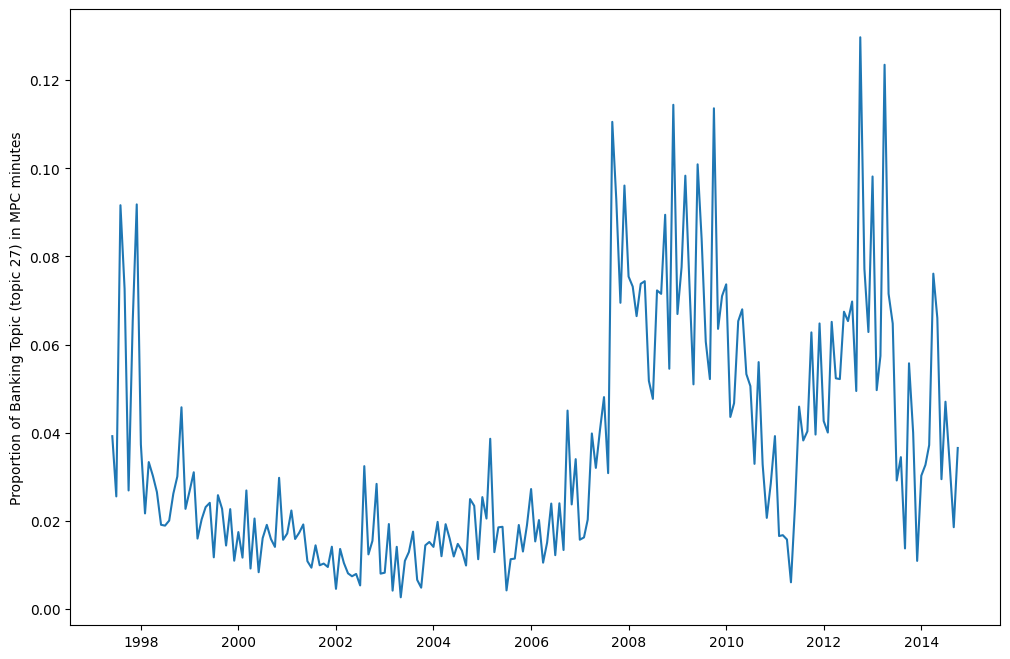

In [57]:
target_topic = 27
plt.figure(figsize=(12,8))
plt.plot(agg_minutes.year_clean.values, agg_minutes[f"T{target_topic}"].values)
plt.ylabel(f"Proportion of Banking Topic (topic {target_topic}) in MPC minutes")
plt.plot()